# Get subnetworks

In [12]:
import numpy as np
import pandas as pd
import networkx as nx

In [13]:
def get_yeastract_data(yeastract_csv_filename, gene_to_orf_filename="tftoorf.csv", as_orf=False):
    '''
    Returns Yeastract network data as a pandas DataFrame.
    '''
    def tf_to_gene(tf_name):
        '''
        Removes trailing "p" from transcription factor name and turn into uppercase.
        '''
        if tf_name[-1] == 'p':
            return tf_name.upper()[:-1]
        else:
            return tf_name
    
    yeastract_data = pd.read_csv(yeastract_csv_filename, sep= ";")
    gene_to_orf_df = pd.read_csv(gene_to_orf_filename)
    
    tf_list = list(yeastract_data['6855'])
    gene_list = list(yeastract_data.columns.values)[1:]
    
    # Fix dataframe so it has right things as rownames.
    yeastract_data = yeastract_data.rename(index=yeastract_data['6855'])
    yeastract_data = yeastract_data.iloc[:, 1:]
    
    tf_list = [tf_to_gene(tf) for tf in tf_list]
    if as_orf:
        gene_to_orf = dict(zip(list(gene_to_orf_df.iloc[:,0]), list(gene_to_orf_df.iloc[:,2])))
        
        rownames = [gene_to_orf[tf] for tf in tf_list]
        # Change to TF if possible, otherwise keep same name.
        colnames = [gene_to_orf.get(gene, gene) for gene in gene_list]
    else:
        rownames = tf_list
        colnames = gene_list
    
    final_data = pd.DataFrame(np.array(yeastract_data), index=rownames, columns=colnames)
    
    return final_data

def get_gasch_data(gasch_data_filename="complete_dataset_gasch.txt", 
                   orf_to_gene_filename="orfname_time_course_fixed.csv",
                   supset=None ,
                   as_orf=False):
    '''
    Returns heat shock time-course data from Gasch as DataFrame.
    '''
    gasch_data = pd.read_csv(gasch_data_filename, sep="\t")
#    gasch_data = gasch_data.iloc[:,:11] # Filter only heat-shock data from first experiment (hs-1).
    
    if not as_orf:
        # Rename as genes.
        orf_to_gene_df = pd.read_csv(orf_to_gene_filename)
        orfs = list(orf_to_gene_df.iloc[:,0])
        genes = list(orf_to_gene_df.iloc[:,3])
        
        # Remove unknowns, keep original name.
        genes = [gene if gene != 'Unknown' else orfs[i] for i, gene in enumerate(genes)]
        orf_to_gene = dict(zip(orfs, genes))
        
        orf_list = list(gasch_data["UID"])
        gene_names = [orf_to_gene.get(orf, orf) for orf in orf_list]
        #print(gene_names)
        gasch_data["UID"] = gene_names
        gasch_data = gasch_data.rename(index=gasch_data["UID"])
        gasch_data = gasch_data.iloc[:, 1:]
        if supset != None:
            to_delete = set(gene_names)-set(supset)
            to_delete_list = list(to_delete)
            gasch_data = gasch_data.drop(to_delete_list)
    return gasch_data
    

def squarify(df, sort=False):
    '''
    Turns Yeastract DataFrame into a square dataframe (i.e. adjacency matrix).
    '''
    cols=list(df.columns)
    rows=list(df.index)
    d = []
    for x in cols:
        if x in rows:
            d.append(list(df.loc[x]))
        else:
            d.append([0]*len(cols))
    A = np.array(d)
    return pd.DataFrame(A, index=cols, columns=cols)

def reorder(target_orf, adj_matrix):
    A = target_orf #input the list of target orf name
    B = adj_matrix #input the adj matrix

    #First we want to extract the header from the adj matrix and compare them with the list

    B_header = list(B)

    AB_diff = list(set(B_header) - set(A))
    #print(set(A)<set(B_header))
    A_total = A + AB_diff
    B = B[A_total]
    B = B.reindex(A_total)
    return B

In [14]:
nx.__version__

'2.0'

In [15]:
yeastract_data_activation = get_yeastract_data("matrix_activator.csv","tftoorf.csv")
yeastract_data_inhibition = get_yeastract_data("matrix_inhibitor.csv","tftoorf.csv")
adj_mat_activation = squarify(yeastract_data_activation)
adj_mat_inhibition = squarify(yeastract_data_inhibition)
adj_matrix=adj_mat_activation-adj_mat_inhibition
cols = list(adj_mat_activation.columns)
gasch_data = get_gasch_data("complete_dataset_gasch.txt","orfname_time_course_fixed.csv",cols)
adj_matrix = reorder(list(gasch_data.index),adj_matrix)
gasch_esr = get_gasch_data("figure3_gasch_paper.cdt","orfname_time_course_fixed.csv",cols)

In [16]:
W = adj_matrix

network = nx.DiGraph(data=np.array(W))
names = list(W)
network = nx.relabel_nodes(network, {i:name for i, name in enumerate(names)})

## 1. Direct heatshock TFs and neighbors.

In [17]:
def get_neighbors_subnetwork(network, starters):
    '''
    Returns network with starter nodes and direct downstream neighbors.
    '''
    neighbors = []
    for tf in starters:
        neighbors.extend(list(network.successors(tf)))
    return network.subgraph(starters + neighbors)

In [18]:
#These transcription factors are the ones we expect to turn on the heat shock response.
heat_shock_starters = ["HSF1", "MSN2", "MSN4", "RLM1", "SWI4"]

neighbors = []
for tf in heat_shock_starters:
    neighbors.extend(list(network.successors(tf)))

In [19]:
G1_full = network.subgraph(heat_shock_starters + neighbors)

In [20]:
len(G1_full.nodes())

789

In [21]:
G1_hsf = get_neighbors_subnetwork(network, ['HSF1'])
print(G1_hsf.nodes())

['EFB1', 'SSA1', 'SCT1', 'HEK2', 'RIB1', 'HHF1', 'REG2', 'RFS1', 'UBC4', 'FES1', 'TKL2', 'TEF2', 'SSE2', 'FTH1', 'KRR1', 'UBX3', 'ARO1', 'YDR154C', 'CPR1', 'HOM2', 'HSP42', 'BSC2', 'PIB1', 'YEL045C', 'ARB1', 'PHM8', 'RPS8b', 'MDJ1', 'PMA1', 'YGL036W', 'PNC1', 'HSF1', 'VPS62', 'BTN2', 'ECL1', 'CHO2', 'TDH3', 'SKI6', 'SNG1', 'YPP1', 'YGR210C', 'SOL4', 'RIE1', 'GRE3', 'DAL7', 'SMC3', 'YJL144W', 'RPA34', 'TAH11', 'CYC1', 'MRT4', 'UFD4', 'SFK1', 'GPM1', 'YKR041W', 'POM33', 'YLR050C', 'PER33', 'AHP1', 'YLR217W', 'GSP1', 'TMA10', 'TSL1', 'ERO1', 'SPG4', 'ILV2', 'RTP1', 'LST8', 'MTQ1', 'YNL134C', 'BSC5', 'IRA2', 'ATG19', 'HSP10', 'BUB3', 'STI1', 'THI72', 'HRK1', 'TYE7', 'AEP3', 'SVL3', 'MRX4', 'YAR1', 'TIP41', 'CUR1', 'MBF1', 'YDR170W-A', 'YBR085C-A']


In [22]:
len(G1_hsf.nodes())

88

## Simulate

In [23]:
from scipy.integrate import odeint

In [24]:
def f(y, t0, A, u, kf):
    return (A - kf * np.identity(len(A))) @ y + u

In [25]:
A = nx.adjacency_matrix(G1_hsf)
A = A.toarray()
A = A.transpose()
A = 0.3 * A

In [26]:
u = 0.05 * np.array([1.0 if node in heat_shock_starters else 0.0 for node in G1_hsf.nodes()])
y0 = [0.0] * len(A)
times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])
kf = 0.1
y = odeint(f, y0=y0, t=times, args=(A, u, kf))

In [27]:
nodes = list(G1_hsf.nodes())
nodes.index("HSF1")

31

In [28]:
y[:,31]

array([ 0.        ,  0.19673467,  0.31606028,  0.38843492,  0.43233236,
        0.47510647,  0.49084218,  0.49876062,  0.49983227])

In [29]:
nodes

['EFB1',
 'SSA1',
 'SCT1',
 'HEK2',
 'RIB1',
 'HHF1',
 'REG2',
 'RFS1',
 'UBC4',
 'FES1',
 'TKL2',
 'TEF2',
 'SSE2',
 'FTH1',
 'KRR1',
 'UBX3',
 'ARO1',
 'YDR154C',
 'CPR1',
 'HOM2',
 'HSP42',
 'BSC2',
 'PIB1',
 'YEL045C',
 'ARB1',
 'PHM8',
 'RPS8b',
 'MDJ1',
 'PMA1',
 'YGL036W',
 'PNC1',
 'HSF1',
 'VPS62',
 'BTN2',
 'ECL1',
 'CHO2',
 'TDH3',
 'SKI6',
 'SNG1',
 'YPP1',
 'YGR210C',
 'SOL4',
 'RIE1',
 'GRE3',
 'DAL7',
 'SMC3',
 'YJL144W',
 'RPA34',
 'TAH11',
 'CYC1',
 'MRT4',
 'UFD4',
 'SFK1',
 'GPM1',
 'YKR041W',
 'POM33',
 'YLR050C',
 'PER33',
 'AHP1',
 'YLR217W',
 'GSP1',
 'TMA10',
 'TSL1',
 'ERO1',
 'SPG4',
 'ILV2',
 'RTP1',
 'LST8',
 'MTQ1',
 'YNL134C',
 'BSC5',
 'IRA2',
 'ATG19',
 'HSP10',
 'BUB3',
 'STI1',
 'THI72',
 'HRK1',
 'TYE7',
 'AEP3',
 'SVL3',
 'MRX4',
 'YAR1',
 'TIP41',
 'CUR1',
 'MBF1',
 'YDR170W-A',
 'YBR085C-A']

In [30]:
from matplotlib import pyplot as plt

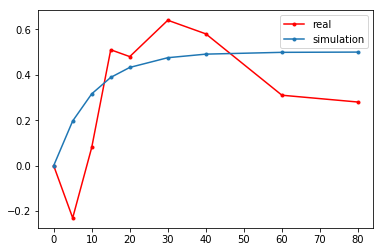

In [31]:
%matplotlib inline
real_data = gasch_data.iloc[:, 2:10].loc["HSF1"]
plt.plot(times, [0] + list(real_data), '.-r', label="real")
plt.plot(times, y[:, 31], '.-', label="simulation")
plt.legend(loc="best")
plt.show()

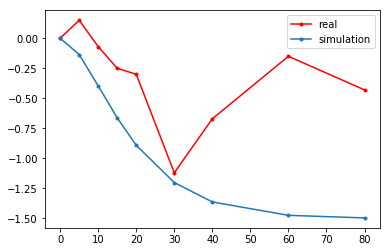

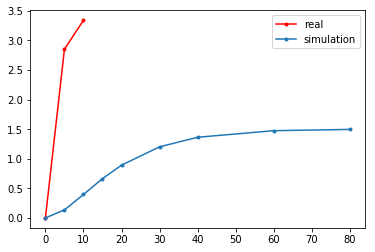

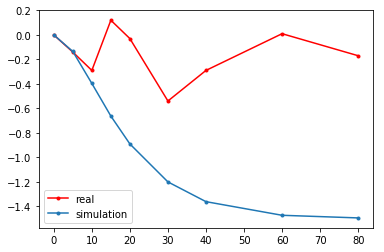

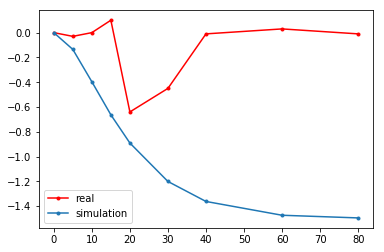

In [123]:
for i in range(4):
    node_name = nodes[i]
    real_data = gasch_data.iloc[:, 2:10].loc[node_name]
    plt.plot(times, [0] + list(real_data), '.-r', label="real")
    plt.plot(times, y[:, i], '.-', label="simulation")
    plt.legend(loc="best")
    plt.show()

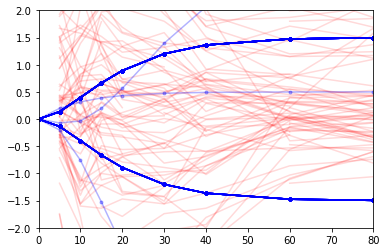

In [145]:
y_data = gasch_data.iloc[:, 2:10].loc[nodes]
#y_data = [0] * len(y_data)
plt.plot(times[1:], np.transpose(y_data), '-r', alpha=0.15)
plt.plot(times, y, '.-b', alpha=0.3)
plt.xlim(0, 80)
plt.ylim(-2, 2)
plt.show()

In [ ]:
plt.plot(times, y, '.-')
plt.show()

## Heat shock factors

In [172]:
heat_shock_starters

['HSF1', 'MSN2', 'MSN4', 'RLM1', 'SWI4']

In [173]:
A = nx.adjacency_matrix(G1_full)
A = A.toarray()
A = A.transpose()
A = 0.3 * A

In [196]:
u = 0.05 * np.array([1.0 if node in heat_shock_starters else 0.0 for node in G1_full.nodes()])
y0 = [0.0] * len(A)
times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])
kf = 0.1
y_full = odeint(f, y0=y0, t=times, args=(A, u, kf))

In [187]:
nodes = list(G1_full.nodes())

In [184]:
heat_shock_starters

['HSF1', 'MSN2', 'MSN4', 'RLM1', 'SWI4']

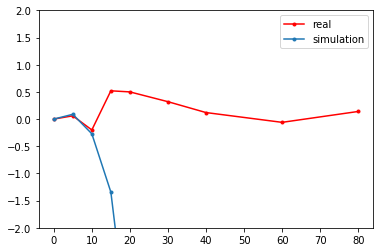

In [199]:
%matplotlib inline
name = "MSN2"
i = nodes.index(name)
real_data = gasch_data.iloc[:, 2:10].loc[name]
plt.plot(times, [0] + list(real_data), '.-r', label="real")
plt.plot(times, y_full[:, i], '.-', label="simulation")
plt.legend(loc="best")
plt.ylim(-2, 2)
plt.show()

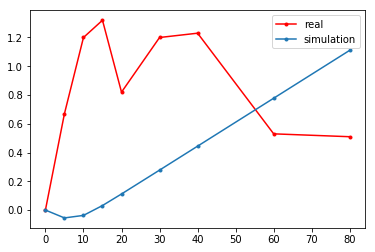

In [193]:
%matplotlib inline
name = "TEC1"
i = nodes.index(name)
real_data = gasch_data.iloc[:, 2:10].loc[name]
plt.plot(times, [0] + list(real_data), '.-r', label="real")
plt.plot(times, y_full[:, i], '.-', label="simulation")
plt.legend(loc="best")
#plt.ylim(-2, 2)
plt.show()

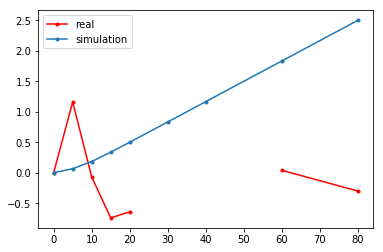

In [194]:
%matplotlib inline
name = "TYE7"
i = nodes.index(name)
real_data = gasch_data.iloc[:, 2:10].loc[name]
plt.plot(times, [0] + list(real_data), '.-r', label="real")
plt.plot(times, y_full[:, i], '.-', label="simulation")
plt.legend(loc="best")
#plt.ylim(-2, 2)
plt.show()

In [160]:
list(G1_full.predecessors("MSN2"))

['TEC1', 'TYE7']

In [162]:
list(G1_full.edges())

[('TEC1', 'FRT2'),
 ('TEC1', 'MYO4'),
 ('TEC1', 'UTP20'),
 ('TEC1', 'ECM13'),
 ('TEC1', 'YBL044W'),
 ('TEC1', 'ECM33'),
 ('TEC1', 'TKL2'),
 ('TEC1', 'KNH1'),
 ('TEC1', 'LYS20'),
 ('TEC1', 'PRR2'),
 ('TEC1', 'ENA1'),
 ('TEC1', 'NRG1'),
 ('TEC1', 'SED1'),
 ('TEC1', 'YDR132C'),
 ('TEC1', 'HSP42'),
 ('TEC1', 'YDR210W'),
 ('TEC1', 'YDR249C'),
 ('TEC1', 'PAM1'),
 ('TEC1', 'GIC2'),
 ('TEC1', 'HXT6'),
 ('TEC1', 'ESF1'),
 ('TEC1', 'YHP1'),
 ('TEC1', 'GNP1'),
 ('TEC1', 'MIT1'),
 ('TEC1', 'UTR2'),
 ('TEC1', 'VHR2'),
 ('TEC1', 'FTR1'),
 ('TEC1', 'SPI1'),
 ('TEC1', 'YER158C'),
 ('TEC1', 'PUG1'),
 ('TEC1', 'RCK1'),
 ('TEC1', 'MPT5'),
 ('TEC1', 'MSB2'),
 ('TEC1', 'MSP1'),
 ('TEC1', 'GSC2'),
 ('TEC1', 'ERG25'),
 ('TEC1', 'MEP1'),
 ('TEC1', 'YGR122W'),
 ('TEC1', 'CRH1'),
 ('TEC1', 'TOS2'),
 ('TEC1', 'YHB1'),
 ('TEC1', 'HXT4'),
 ('TEC1', 'BMT5'),
 ('TEC1', 'PRM5'),
 ('TEC1', 'SIM1'),
 ('TEC1', 'IMA3'),
 ('TEC1', 'MET28'),
 ('TEC1', 'FLO11'),
 ('TEC1', 'DAL7'),
 ('TEC1', 'UBX6'),
 ('TEC1', 'CIS3'),
 ('TE

In [ ]:
def error_function(x):
    